In [1]:
import os
import sys
import torch

from matplotlib import pyplot as plt

In [2]:
# set up args
import argparse

parser = argparse.ArgumentParser()
# for dataset
parser.add_argument('--data', default='./dataset/dataset_v2')
parser.add_argument('--train_list', default='./dataset/dataset_v2/sample.txt')
parser.add_argument('--query_list', default='./dataset/dataset_v2/query.txt')
# for model
parser.add_argument('--supervised', default=0)
parser.add_argument('--num_class', default=181)
parser.add_argument('--softmax', default=1, type=int)
parser.add_argument('--s', default=30.0, type=float)
parser.add_argument('--m', default=0.15, type=float)
parser.add_argument('--out_dim', default=2048, type=int)
parser.add_argument('--temperature', default=0.07)
# for training
parser.add_argument('--max_epochs', default=10)
parser.add_argument('--batch_size', default=128)
parser.add_argument('--lr', default=3e-4)
parser.add_argument('--weight_decay', default=1e-4)
# for visualization
parser.add_argument('--log_steps', default=1)
parser.add_argument('--ckpt_dir', default="output/certify/vit_lr0.0001_bs32_epoch20_translate/")
parser.add_argument('--load_epoch', default=10)

args = parser.parse_args(args=[])
print(args)

Namespace(batch_size=128, ckpt_dir='output/certify/vit_lr0.0001_bs32_epoch20_translate/', data='./dataset/dataset_v2', load_epoch=10, log_steps=1, lr=0.0003, m=0.15, max_epochs=10, num_class=181, out_dim=2048, query_list='./dataset/dataset_v2/query.txt', s=30.0, softmax=1, supervised=0, temperature=0.07, train_list='./dataset/dataset_v2/sample.txt', weight_decay=0.0001)


In [3]:
# set up model
from supervised.model import Model, DOLG, TransformerModel
from unsupervised.model import ResNetSimCLR, VitSimCLR

if args.supervised:
    model = TransformerModel(num_class=args.num_class, args=args).cuda()
else:
    model = VitSimCLR(out_dim=args.out_dim, num_class=args.num_class).cuda()
model.load_state_dict(torch.load(os.path.join(args.ckpt_dir, "model_{:0>2d}.ckpt".format(args.load_epoch - 1))))
model.eval()

VitSimCLR(
  (backbone): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): La

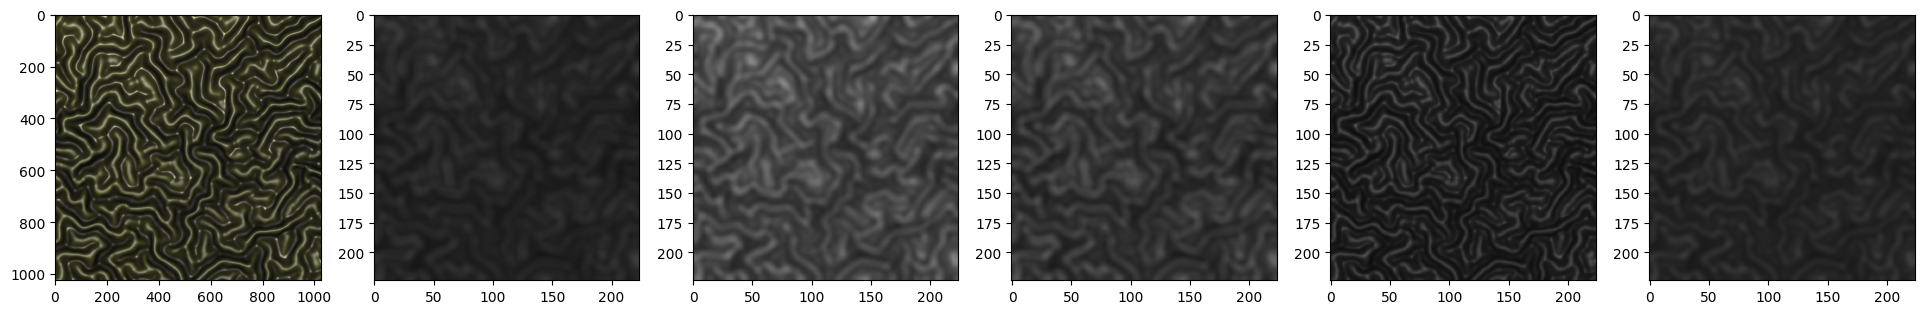

In [5]:
from PIL import Image
import torchvision.transforms as T

image = Image.open("dataset/dataset_v2/test/00000.jpg")
transforms = T.Compose([
    T.Resize((224, 224)),
    T.Grayscale(3),
    T.RandomApply([T.ColorJitter(brightness=.4, contrast=.4, saturation=.2)], p=0.5),
    T.GaussianBlur(kernel_size=(9, 9), sigma=(0.1, 5))
])
image_list = [transforms(image) for _ in range(5)]
image_list = [image] + image_list
plt.figure(figsize=(24, 4))
for i, im in enumerate(image_list):
    plt.subplot(1, 6, i+1)
    plt.imshow(im)
plt.show()
plt.close()

In [6]:
import time

def calculate_overlap(coord1, coord2):
    x1, y1, x2, y2 = coord1
    x3, y3, x4, y4 = coord2
    x_overlap = max(0, min(x2, x4) - max(x1, x3))
    y_overlap = max(0, min(y2, y4) - max(y1, y3))
    overlap_area = x_overlap * y_overlap
    overlap_area = float(overlap_area) / ((x2 - x1) * (y2 - y1))
    return overlap_area

def imtensor_2_numpy(x):
    return x.permute(1, 2, 0).numpy()

def certify(im_certify, im_full_label, model, coord, train_transforms, test_transforms, stride=1024):
    _, h, w = im_full_label.size()
    _, x, y = im_certify.size()
    n1 = (h - x - 1) // stride + 2
    n2 = (w - y - 1) // stride + 2
    im_certify = train_transforms(im_certify)
    im_list = [im_certify]
    overlap_list = []
    for i in range(n1):
        for j in range(n2):
            x1 = i * stride if i != n1 - 1 else h - x
            y1 = j * stride if j != n2 - 1 else w - y
            x2 = x1 + x
            y2 = y1 + y
            im_slide_window = im_full_label[:, x1:x2, y1:y2]
            im_slide_window = test_transforms(im_slide_window)
            overlap = calculate_overlap(coord, (x1, y1, x2, y2))
            im_list.append(im_slide_window)
            overlap_list.append(overlap)
    
    images = torch.stack(im_list)
    overlap = torch.tensor(overlap_list).reshape(n1, n2)
    
    n3 = (images.shape[0] - 1) // 128 + 1
    feature_list = []
    with torch.no_grad():
        for i in range(n3):
            images_batch = images[i * 128:min(i * 128 + 128, images.shape[0])]
            images_batch = images_batch.cuda()
            if args.supervised:
                features, _ = model(images_batch, None, args)
            else:
                features, _ = model(images_batch)
            features = features / torch.norm(features, dim=-1, keepdim=True)
            feature_list.append(features.detach().cpu())
        features = torch.cat(feature_list, dim=0)
    q_feature = features[0]
    im_features = features[1:]
    
#     dis = torch.exp(-torch.sqrt(torch.sum((q_feature.repeat(im_features.shape[0], 1) - im_features) ** 2, dim=-1)))
    dis = torch.matmul(q_feature, im_features.T)
    dis = dis.reshape(n1, n2)
    
    return dis, overlap
    

train_transforms = T.Compose([
    T.Resize((224, 224)),
    T.Grayscale(3),
    T.RandomApply([T.ColorJitter(brightness=.4, contrast=.4, saturation=.2)], p=0.5),
    T.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 5)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = T.Compose([
    T.Resize((224, 224)),
    T.Grayscale(3),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

label = 0
coord = (2319, 1806, 3343, 2830)
to_tensor = T.ToTensor()
im_certify = to_tensor(Image.open("dataset/dataset_v2/test/00000.jpg"))
im_full_label = to_tensor(Image.open("dataset/dataset_v2/full/full_label_{:0>5d}.jpg".format(0)))
tic = time.time()
dis, overlap = certify(im_certify, im_full_label, model, coord, test_transforms, test_transforms, stride=100)
toc = time.time()
print("time:", toc - tic)

time: 7.009226322174072


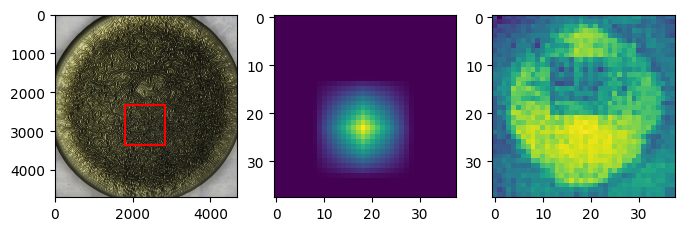

In [7]:
import numpy as np

def plot_coord(coord):
    x1, y1, x2, y2 = coord
    plt.plot([y1, y2], [x1, x1], c="r")
    plt.plot([y1, y2], [x2, x2], c="r")
    plt.plot([y1, y1], [x1, x2], c="r")
    plt.plot([y2, y2], [x1, x2], c="r")

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.imshow(imtensor_2_numpy(im_full_label))
plot_coord(coord)
plt.subplot(1, 3, 2)
plt.imshow(overlap)
plt.subplot(1, 3, 3)
plt.imshow(dis)
plt.show()
plt.close()

label shape: torch.Size([3, 4700, 4691]) stride: 1024
dis shape: torch.Size([5, 5])


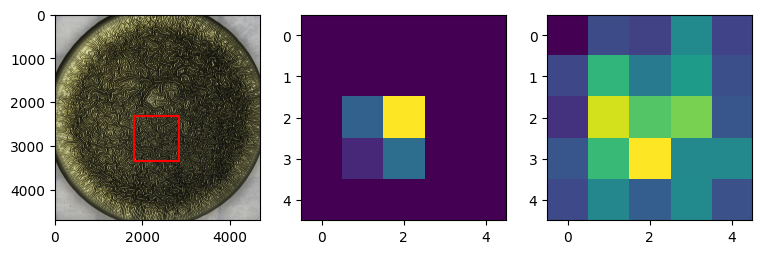

label shape: torch.Size([3, 2545, 2858]) stride: 512
dis shape: torch.Size([4, 5])


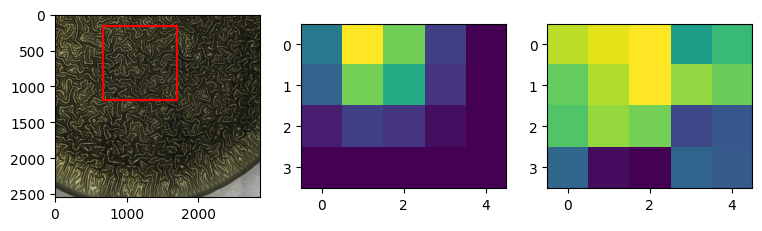

label shape: torch.Size([3, 1858, 1858]) stride: 256
dis shape: torch.Size([5, 5])


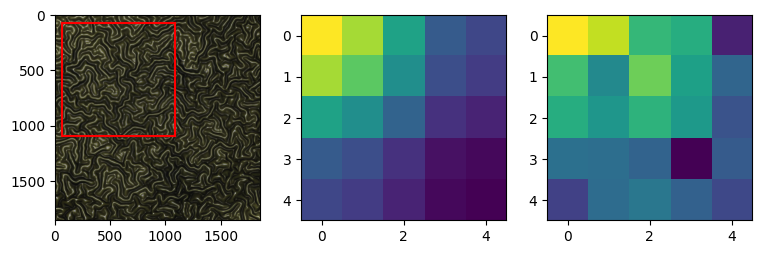

label shape: torch.Size([3, 1232, 1232]) stride: 128
dis shape: torch.Size([3, 3])


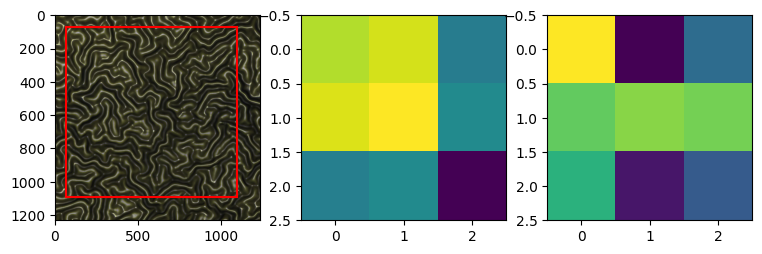

label shape: torch.Size([3, 1076, 1076]) stride: 64
dis shape: torch.Size([2, 2])


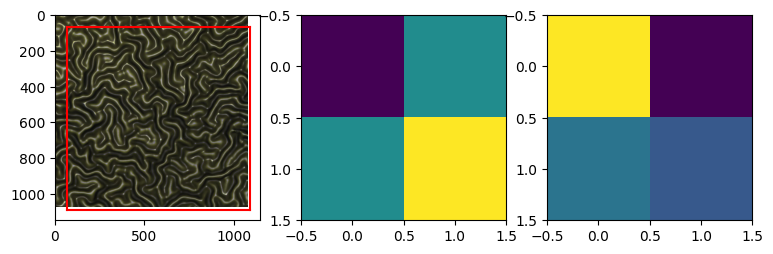

label shape: torch.Size([3, 1037, 1037]) stride: 32
dis shape: torch.Size([2, 2])


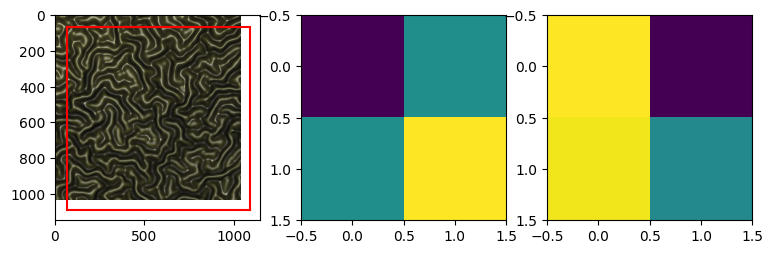

label shape: torch.Size([3, 1027, 1027]) stride: 16
dis shape: torch.Size([2, 2])


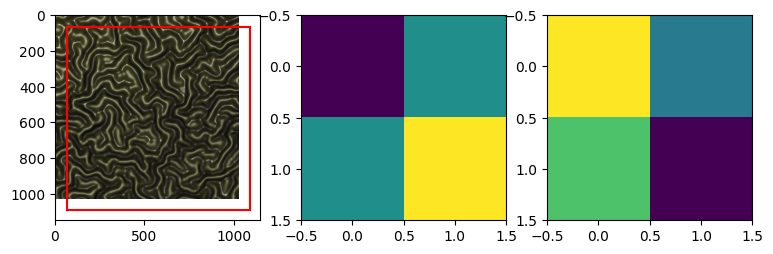

label shape: torch.Size([3, 1024, 1024]) stride: 8
dis shape: torch.Size([1, 1])


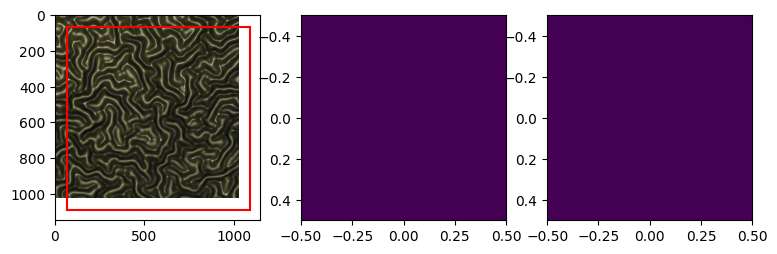

time: 4.853413105010986
tensor(0.9773) tensor(0.8707)


In [8]:
import math

def recursive_certify(im_certify, im_full_label, model, coord, train_transforms, test_transforms, stride=1024, visual=False):
    dis, overlap = certify(im_certify, im_full_label, model, coord, test_transforms, test_transforms, stride=stride)
    if visual:
        print("label shape:", im_full_label.shape, "stride:", stride)
        print("dis shape:", dis.shape)
        plt.figure(figsize=(9, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(imtensor_2_numpy(im_full_label))
        plot_coord(coord)
        plt.subplot(1, 3, 2)
        plt.imshow(overlap)
        plt.subplot(1, 3, 3)
        plt.imshow(dis)
        plt.show()
        plt.close()
    if stride == 1 or dis.shape[0] == dis.shape[1] == 1:
        return torch.max(dis), torch.max(overlap)
    else:
        n1, n2 = dis.shape
        _, h, w = im_full_label.shape
        _, x, y = im_certify.shape
        # calculate max coord
        max_idx = torch.argmax(dis)
        max_i = max_idx // n2
        max_j = max_idx % n2
        max_x1 = max_i * stride if max_i != n1 - 1 else h - x
        max_y1 = max_j * stride if max_j != n2 - 1 else w - y
        # calculate select area
        area = float((h - x) * (w - y)) / 4
        length = int(math.sqrt(area)) + x
        new_x1 = max(max_x1 + x // 2 - length // 2, 0)
        new_x2 = min(max_x1 + x // 2 + length // 2, h)
        new_y1 = max(max_y1 + y // 2 - length // 2, 0)
        new_y2 = min(max_y1 + y // 2 + length // 2, w)
        assert max_x1 >= new_x1 and max_x1 + x <= new_x2 and max_y1 >= new_y1 and max_y1 + y <= new_y2
        # calculate new coord and new full label
        new_coord = (coord[0]-new_x1, coord[1]-new_y1, coord[2]-new_x1, coord[3]-new_y1)
        new_im_full_label = im_full_label[:, new_x1:new_x2, new_y1:new_y2]
        
        return recursive_certify(im_certify, new_im_full_label, model, new_coord, train_transforms, test_transforms, stride // 2, visual=visual)
    
label = 0
coord = (2319, 1806, 3343, 2830)
to_tensor = T.ToTensor()
im_certify = to_tensor(Image.open("dataset/dataset_v2/test/00000.jpg"))
im_full_label = to_tensor(Image.open("dataset/dataset_v2/full/full_label_{:0>5d}.jpg".format(0)))
tic = time.time()
dis, overlap = recursive_certify(im_certify, im_full_label, model, coord, train_transforms, test_transforms, stride=1024, visual=True)
toc = time.time()
print("time:", toc - tic)

print(dis, overlap)

In [9]:
import pickle
import datetime

with open("query_dic.pk", "rb") as f:
    query_dic = pickle.load(f)

cnt = 0
true_pair = []
false_pair = []
overlap_list = []
to_tensor = T.ToTensor()
print("{} / 1067".format(0), datetime.datetime.now())
for ii, im_pth in enumerate(query_dic.keys()):
    if (ii + 1) % 50 == 0:
        print("{} / 1067".format(ii + 1), datetime.datetime.now())
    label = int(query_dic[im_pth]["label"])
    coord = query_dic[im_pth]["coord"]
    top10 = query_dic[im_pth]["top10"][:5]
    top10 = torch.unique(top10)
    query_dic[im_pth]["certify_label"] = []
    query_dic[im_pth]["certify_value"] = []
    query_dic[im_pth]["certify_overlap"] = []
    for i in range(top10.shape[0]):
        im_certify = to_tensor(Image.open(im_pth))
        im_full_label = to_tensor(Image.open("dataset/dataset_v2/full/full_label_{:0>5d}.jpg".format(top10[i].item())))
        dis, overlap = recursive_certify(im_certify, im_full_label, model, coord, train_transforms, test_transforms, stride=512)
        query_dic[im_pth]["certify_label"].append(top10[i].item())
        query_dic[im_pth]["certify_value"].append(dis.item())
        query_dic[im_pth]["certify_overlap"].append(overlap.item())

0 / 1067 2023-06-27 18:55:39.282193
50 / 1067 2023-06-27 18:57:33.055586
100 / 1067 2023-06-27 18:59:27.303259
150 / 1067 2023-06-27 19:01:26.777590
200 / 1067 2023-06-27 19:03:15.354575
250 / 1067 2023-06-27 19:04:55.914680
300 / 1067 2023-06-27 19:06:35.024671
350 / 1067 2023-06-27 19:08:17.888198
400 / 1067 2023-06-27 19:10:01.912506
450 / 1067 2023-06-27 19:11:48.326127
500 / 1067 2023-06-27 19:13:23.929412
550 / 1067 2023-06-27 19:15:03.865011
600 / 1067 2023-06-27 19:16:49.542745
650 / 1067 2023-06-27 19:18:25.824350
700 / 1067 2023-06-27 19:19:53.881180
750 / 1067 2023-06-27 19:21:40.126007
800 / 1067 2023-06-27 19:23:10.747492
850 / 1067 2023-06-27 19:24:46.049502
900 / 1067 2023-06-27 19:26:31.345427
950 / 1067 2023-06-27 19:27:58.055841
1000 / 1067 2023-06-27 19:29:47.033367
1050 / 1067 2023-06-27 19:31:22.800788


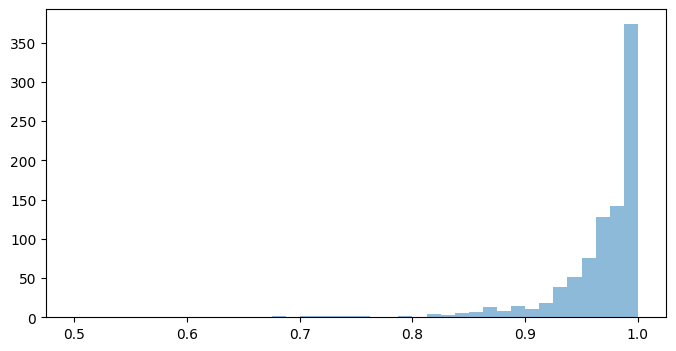

In [13]:
# plot overlap
overlap_list = []
for ii, im_pth in enumerate(query_dic.keys()):
    zipped = zip(query_dic[im_pth]["certify_label"], query_dic[im_pth]["certify_value"], query_dic[im_pth]["certify_overlap"])
    for label, value, overlap in zipped:
        if query_dic[im_pth]["label"] == label:
            overlap_list.append(value)

plt.figure(figsize=(8, 4))
plt.hist(overlap_list, bins=40, range=(0.5, 1.0), alpha=0.5)
plt.show()
plt.close()

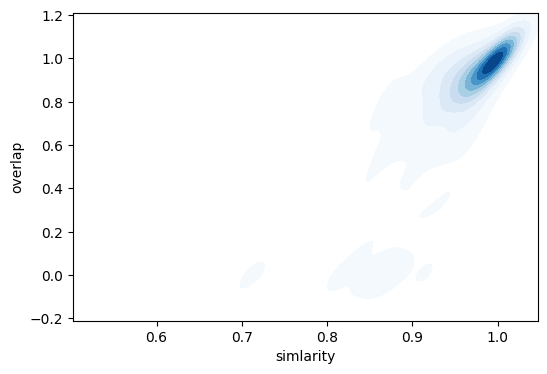

In [14]:
import seaborn as sns

value_overlap_list = []
for ii, im_pth in enumerate(query_dic.keys()):
    zipped = zip(query_dic[im_pth]["certify_label"], query_dic[im_pth]["certify_value"], query_dic[im_pth]["certify_overlap"])
    for label, value, overlap in zipped:
        if query_dic[im_pth]["label"] != -1:
            value_overlap_list.append([value, overlap])
value_overlap_list = np.array(value_overlap_list)

plt.figure(figsize=(6, 4))
sns.kdeplot(x=value_overlap_list[:, 0], y=value_overlap_list[:, 1], cmap="Blues", fill=True)
plt.xlabel("simlarity")
plt.ylabel("overlap")
plt.show()
plt.close()

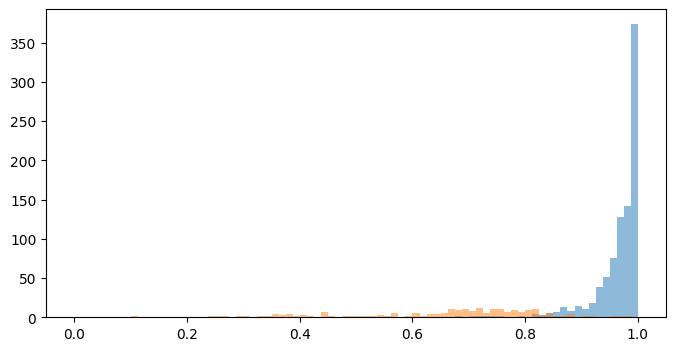

In [15]:
# plot hist
true_pair_value = []
false_pair_value = []
for ii, im_pth in enumerate(query_dic.keys()):
    zipped = zip(query_dic[im_pth]["certify_label"], query_dic[im_pth]["certify_value"], query_dic[im_pth]["certify_overlap"])
    for label, value, overlap in zipped:
        if query_dic[im_pth]["label"] == label:
            true_pair_value.append(value)
        else:
            false_pair_value.append(value)
plt.figure(figsize=(8, 4))
plt.hist(true_pair_value, bins=80, range=(0.0, 1.0), alpha=0.5)
plt.hist(false_pair_value, bins=80, range=(0.0, 1.0), alpha=0.5)
plt.show()
plt.close()

In [21]:
thre = 0.85
tp = tn = fp = fn = 0
pos_cnt = neg_cnt = pos_total = neg_total = 0
for ii, im_pth in enumerate(query_dic.keys()):
    zipped = zip(query_dic[im_pth]["certify_label"], query_dic[im_pth]["certify_value"], query_dic[im_pth]["certify_overlap"])
    flag = False
    for label, value, overlap in zipped:
        if query_dic[im_pth]["label"] == label:
            if value >= thre:
                tp += 1
                flag = True
            else:
                fn += 1
        else:
            if value >= thre:
                fp += 1
                flag = True
            else:
                tn += 1
    if query_dic[im_pth]["label"] != -1 and flag:
        pos_cnt += 1
    elif (query_dic[im_pth]["label"] == -1 and not flag):
        neg_cnt += 1
    if query_dic[im_pth]["label"] != -1:
        pos_total += 1
    else:
        neg_total += 1
        
pre = float(tp) / (tp + fp)
re = float(tp) / (tp + fn)
fre = float(tn) / (tn + fp)
f1 = 2 *  pre * re / (pre + re)
print("precision:", pre)
print("recall:", re)
print("false recall:", fre)
print("f1 score:", f1)
print()

certify_acc = float(pos_cnt + neg_cnt) / (pos_total + neg_total)
certify_acc_pos = float(pos_cnt) / pos_total
certify_acc_neg = float(neg_cnt) / neg_total
print("certify accuracy:", certify_acc)
print("certify positive accuracy:", certify_acc_pos)
print("certify negative accuracy:", certify_acc_neg)

precision: 0.9865771812080537
recall: 0.9778270509977827
false recall: 0.9439252336448598
f1 score: 0.9821826280623608

certify accuracy: 0.9700093720712277
certify positive accuracy: 0.974585635359116
certify negative accuracy: 0.9444444444444444


In [17]:
print(tp + tn + fp + fn)
print(pos_total + neg_total)
print(float(tp + tn + fp + fn) / (pos_total + neg_total))

1116
1067
1.0459231490159324
